# Dynamic Asset Allocation

http://seekingalpha.com/article/1477621-dynamic-asset-allocation-for-practitioners

** NOTE: zipline only works with 32 bit python 2.7 **

In [15]:
import pandas as pd
import time, datetime as dt

%matplotlib inline
import numpy as np
import pytz
from collections import OrderedDict

import os
#os.chdir("C:/Users/Dave/Google Drive/NOTEBOOKS")
os.chdir('E:\\notebooks')
from finhelpers3 import *
from mlhelpers3 import *

def side_by_side(*objs, **kwds):
    from pandas.core.common import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    
import math

## The Data Path

In [2]:
#data_path = "E:\\NOTEBOOKS\\WIP\\data\\"
data_path = 'G:\\Python Resources\\DATA\\'
#data_path = 'C:\\Users\\Dave\\Google Drive\NOTEBOOKS\\WIP\\005. CCM\\data\\'
#data_path = 'G:\\Anaconda3-32bit\\envs\\py2.7-32\\NOTEBOOKS\\WIP\\005. CCM\\data\\'

## PART I - Ranking assets based on price momentum

### Get the raw data from Yahoo

The ten asset classes we will use for all testing are:

1. Commodities (DB Liquid Commodities Index: DBC)
2. Gold (NYSEARCA:GLD)
3. U.S. Stocks (Fama French top 30% by market capitalization: VTI)
4. European Stocks (Stoxx 350 Index: IEV)
5. Japanese Stocks (MSCI Japan: EWJ)
6. Emerging Market Stocks (MSCI EM: EEM)
7. U.S. REITs (Dow Jones U.S. Real Estate Index: ICF)
8. International REITs (Dow Jones Int'l Real Estate Index: RWX)
9. Intermediate Treasuries (Barclays 7-10 Year Treasury Index: IEF)
10. Long Treasuries (Barclays 20+ Year Treasury Index: TLT)

In [2]:
#from zipline.utils.factory import load_bars_from_yahoo

In [4]:
symbols = ['DBC', 'GLD', 'VTI', 'IEV', 'EWJ', 'EEM', 'ICF', 'RWX', 'IEF', 'TLT']
#*****************************************************************
# Load historical data
#****************************************************************** 

start_date = dt.datetime(2003,1,1)
#end_date = dt.datetime(2012,8,31)
end_date = dt.datetime.today()

try :
	data = pd.read_pickle(data_path + 'MyDAA1.pkl')
except :
    # this uses finlib to load data
    data = get_history(symbols, start_date, end_date, data_path)
    data.major_axis = data.major_axis.tz_localize(pytz.utc)
    data.minor_axis = np.array(['open', 'high', 'low', 'close', 'volume', 'price'], dtype=object)
    data.to_pickle(data_path + 'MyDAA1.pkl')
#dp_d = load_bars_from_yahoo(stocks = stocks)
dp_d = data

DBC
Refresh data.. 
 UPDATED.. 
GLD
Refresh data.. 
 UPDATED.. 
VTI
Refresh data.. 
 UPDATED.. 
IEV
Refresh data.. 
 UPDATED.. 
EWJ
Refresh data.. 
 UPDATED.. 
EEM
Refresh data.. 
 UPDATED.. 
ICF
Refresh data.. 
 UPDATED.. 
RWX
Refresh data.. 
 UPDATED.. 
IEF
Refresh data.. 
 UPDATED.. 
TLT
Refresh data.. 
 UPDATED.. 


In [3]:
# can also load data from disk, if available
ETFdata = {}
symbols = ['DBC', 'GLD', 'VTI', 'IEV', 'EWJ', 'EEM', 'ICF', 'RWX', 'IEF', 'TLT']
for s in symbols:
    ETFdata[s] = pd.read_csv(data_path + s + '.csv', parse_dates=True, index_col='Date').sort_index(ascending=True)
dp_d = pd.Panel(ETFdata)
dp_d

<class 'pandas.core.panel.Panel'>
Dimensions: 10 (items) x 5187 (major_axis) x 6 (minor_axis)
Items axis: DBC to VTI
Major_axis axis: 1996-04-01 00:00:00 to 2016-11-04 00:00:00
Minor_axis axis: Open to Adj Close

In [4]:
inception_dates = pd.DataFrame([dp_d[ticker].first_valid_index().date() for ticker in dp_d.keys()], index=dp_d.keys(), columns=['inception'])
inception_dates

,inception
DBC,2006-02-06
EEM,2003-04-14
EWJ,1996-04-01
GLD,2004-11-18
ICF,2001-02-02
IEF,2002-07-30
IEV,2000-07-28
RWX,2006-12-19
TLT,2002-07-30
VTI,2001-06-15


In [5]:
# drop all data before latest inception date
dp_d = dp_d.ix[:,inception_dates.max()[0]:,:]
dp_d.to_pickle(data_path + 'MyDAA1.pkl')

In [3]:
#####################################################################
######################################################################

# If the data was previously saved, start here

########################################################################
#########################################################################

dp_d = pd.read_pickle(data_path + 'MyDAA1.pkl')
dp_d

<class 'pandas.core.panel.Panel'>
Dimensions: 10 (items) x 2488 (major_axis) x 6 (minor_axis)
Items axis: DBC to VTI
Major_axis axis: 2006-12-19 00:00:00 to 2016-11-04 00:00:00
Minor_axis axis: Open to Adj Close

In [4]:
# create datpanels for weekly, monthly, quarterly, bi-annual and annual prices
period = {'w': 5, 'm': 21, 'q':63, 'b': 126, 'y':252}
for interval in period:
    dd = {}
    for item in dp_d.items:
        new_index = [dp_d[item].index[i * period[interval]] for i in range(len(dp_d[item])//period[interval])]
        df = dp_d[item].reindex(index=new_index)
        dd[item] = df
    exec("dp_" + interval + "=pd.Panel(dd)")

### Prepare the strat data

In [5]:
# Strategy parameters

capital = 100000.

portfolios = {}

# lookback months
days_per_month = 21
lookback = [months *  days_per_month for months in [1, 3, 6, 9, 12]]

# stock rankings to include at rebalance
top_n = [2, 3, 4, 5]

#11 asset universes
universes = [list(dp_d.items)]
for i in range(9):
    tmp = list(dp_d.items.copy())
    del tmp[i]
    universes.append(tmp)

 The strat data will be organized in multiple dataframes
 
 The columns will be the stock names, the df name will be the parameter
 
1. Total Return Momentum
2. SMA Differential
3. Price to SMA Differential
4. SMA Instantaneous Slope
5. Price Percent Rank
6. Z-Score
7. Z-Distribution
8. T-Distribution

In [43]:
# Adjusted prices

prices = dp_d.ix[:,:,"Adj Close"].dropna().copy()
prices.tail()

,DBC,EEM,EWJ,GLD,ICF,IEF,IEV,RWX,TLT,VTI
Date,,,,,,,,,,
2016-03-29,13.36,33.665482,11.549016,118.760002,102.910004,109.445135,39.029999,40.924335,129.323885,104.540001
2016-03-30,13.31,34.012752,11.509329,117.099998,102.529999,109.296019,39.450001,41.261488,127.962265,104.940002
2016-03-31,13.29,33.982987,11.320814,117.639999,103.160004,109.693670,39.110001,41.112742,128.870007,104.820000
2016-04-01,13.06,33.883768,11.043003,116.930000,103.239998,109.661809,38.770000,40.745842,129.206164,105.480003
2016-04-04,12.88,33.476965,11.043003,116.150002,103.080002,109.791242,38.820000,40.626849,129.285263,105.040001


## Momentum

In [153]:
import scipy.stats as st 
import numpy as np
import pandas as pd

def standardize (df):
    '''
    Routine to standardize dataframe using the formula
    st. mom = |momentum(i)| \ |sum(momentum)| * sign(momentum(i))
    '''
    import math
    sign = lambda x: math.copysign(1, x)
    df_sign = pd.DataFrame([[sign(df.ix[i][j]) for j in range(len(df.columns))] for i in range(len(df))],\
                       index=df.index, columns=df.columns)
    df_tmp = pd.DataFrame([abs(df.ix[i]) / abs(df.sum( axis=1)).values[i] for i in range(len(df))],\
                       index=df.index, columns=df.columns)
    return df_sign.mul(df_tmp)

def zscore(prices, lookback):
    z = prices - prices.rolling(window=lookback).mean()
    return z / prices.rolling(window=lookback).std()

def price_percent_rank(prices, lookback):
    price_percent_rank = pd.DataFrame([[percentileofscore(prices.iloc[i:i+lookback][s], 
                                                          prices.iloc[i+lookback-1][s]) 
                                        for s in prices.columns] 
                                       for i in range(len(prices)-lookback)], 
                                      index=prices.index[lookback:len(prices)], 
                                      columns=prices.columns)
    return price_percent_rank

def t_dist(prices, lookback):
    # use t_score and t_dist if lookback > 30, else use z_score, z_dist
    t_score = (prices - prices.rolling(window=lookback).mean()) / prices.rolling(window=lookback).std() / np.sqrt(lookback)
    return t_score.apply(st.t.cdf, df=lookback - 1 )

OrderedDict(( 
        ('total_return', lambda prices, lookback: prices.pct_change(lookback)), 
        ('SMA_diff', lambda prices, lookback: prices.rolling(window=lookback / 10).mean() / prices.rolling(window=lookback).mean() - 1.),
        ('price_to_SMA_diff', lambda prices, lookback: prices.divide(prices.rolling(window=lookback).mean())),
        ('SMA_inst_slope', lambda prices, lookback: prices.rolling(window=lookback).mean().pct_change()),
        ('Price_percent_rank', lambda prices, lookback: price_percent_rank(prices, lookback)),
        ('zscore', lambda prices, lookback: zscore(prices, lookback)),
        ('z_dist', lambda prices, lookback: zscore(prices, lookback).apply(st.norm.cdf)),
        ('t_dist', lambda prices, lookback : t_dist(prices, lookback))
        
                  ))

OrderedDict([('total_return', <function __main__.<lambda>>),
             ('SMA_diff', <function __main__.<lambda>>),
             ('price_to_SMA_diff', <function __main__.<lambda>>),
             ('SMA_inst_slope', <function __main__.<lambda>>),
             ('Price_percent_rank', <function __main__.<lambda>>),
             ('zscore', <function __main__.<lambda>>),
             ('z_dist', <function __main__.<lambda>>)])

## The following all need to be edited to use the 8 momentum measures

In [7]:
# create df for each of the 5 lookback periods
for window in lookback:
    df_name = 'TRMomentum' + str(window)
    exec(df_name + " = prices.pct_change(window)")
    
# standardize using the formula st. mom = |momentum(i)| \ |sum(momentum)| * sign(momentum(i))


In [9]:
df_TRMomentum21_std = standardize(TRMomentum21)
df_TRMomentum21_std[21:25]

,DBC,EEM,EWJ,GLD,ICF,IEF,IEV,RWX,TLT,VTI
Date,,,,,,,,,,
2007-01-23,-0.237441,0.227969,0.147225,0.218082,0.379329,-0.054899,0.053815,0.341155,-0.106600,0.031365
2007-01-24,-0.256556,0.187833,0.159649,0.213690,0.367840,-0.046352,0.101039,0.293485,-0.093400,0.072771
2007-01-25,-0.386949,0.063729,0.074406,0.326728,0.795773,-0.126807,0.033795,0.396111,-0.233019,0.056234
2007-01-26,-0.297804,0.069777,0.044584,0.257506,0.761955,-0.079186,0.087124,0.230852,-0.154007,0.079199


In [10]:
def strategy_backtest (p_name, df_scores, prices, lookback_days=21, n_top=2, plot=False, print_out=False, save_metrics=True) :

    global portfolios
    
    print (p_name)
    
    portfolios = add_portfolio(p_name, portfolios)

    period_ends = endpoints(df_scores.index[0], df_scores.index[-1], lookback_days, df_scores.index)
    
    scores = df_scores
    p = scores.loc[period_ends]
    rankings = p.rank(axis=1, ascending=False)

    weights = ntop(rankings, n_top)
    
    p_value, p_holdings, p_weights  = backtest(prices, weights, capital, offset=1, commission=0.)
    
    if save_metrics:
        save_portfolio_metrics (portfolios, p_name, period_ends, prices, \
                            p_value, p_weights, p_holdings, path=None)
    
#     if print_out:
#         print_stats(p_value)
    
#     if plot :
#         p_value.plot(figsize=(15, 10), grid=True)
    
    return p_value, p_holdings, p_weights

In [11]:
df_scores = df_TRMomentum21_std.dropna()
p_name = "TRMomentum21"
n_top = 2

p_value, p_holdings, p_weights = strategy_backtest (p_name, df_scores, prices, lookback_days=21, n_top=2, plot=True, print_out=True, save_metrics=True)

TRMomentum21
FIRST BUY DATE = 2007-02-23 00:00:00



In [12]:
portfolios.keys()

dict_keys(['TRMomentum21'])

#### Run backtests for all cases and save results

In [13]:
def tr_momentum(prices, lookback, stdz=True):
    if stdz:
        return standardize(prices.pct_change(lookback))
    else:
        return prices.pct_change(lookback)

In [ ]:
O

In [14]:
func = tr_momentum

for u_no, universe in enumerate(universes):
    prices = dp_d.ix[:,:,"Adj Close"][universe]
    
    for window in lookback:
        df_scores = func(prices, window)
        
        for n_top in top_n:
            
            p_name = "U" + str(u_no + 1) + " :  TRMomentum (" + str(window) + ", " + str(n_top) + ")" 
            print ('\n=================================================================\n\n{}'.format(p_name))
            
            
            p_value, p_holdings, p_weights = strategy_backtest (p_name, df_scores, prices, 
                                                                lookback_days=window, n_top=n_top, 
                                                                plot=False, print_out=False, save_metrics=True)
            print ('\n\n=================================================================\n\n')                     



U1 :  TRMomentum (21, 2)
U1 :  TRMomentum (21, 2)
FIRST BUY DATE = 2007-01-24 00:00:00







U1 :  TRMomentum (21, 3)
U1 :  TRMomentum (21, 3)
FIRST BUY DATE = 2007-01-24 00:00:00







U1 :  TRMomentum (21, 4)
U1 :  TRMomentum (21, 4)
FIRST BUY DATE = 2007-01-24 00:00:00







U1 :  TRMomentum (21, 5)
U1 :  TRMomentum (21, 5)
FIRST BUY DATE = 2007-01-24 00:00:00







U1 :  TRMomentum (63, 2)
U1 :  TRMomentum (63, 2)
FIRST BUY DATE = 2007-03-26 00:00:00







U1 :  TRMomentum (63, 3)
U1 :  TRMomentum (63, 3)
FIRST BUY DATE = 2007-03-26 00:00:00







U1 :  TRMomentum (63, 4)
U1 :  TRMomentum (63, 4)
FIRST BUY DATE = 2007-03-26 00:00:00







U1 :  TRMomentum (63, 5)
U1 :  TRMomentum (63, 5)
FIRST BUY DATE = 2007-03-26 00:00:00







U1 :  TRMomentum (126, 2)
U1 :  TRMomentum (126, 2)
FIRST BUY DATE = 2007-06-25 00:00:00







U1 :  TRMomentum (126, 3)
U1 :  TRMomentum (126, 3)
FIRST BUY DATE = 2007-06-25 00:00:00







U1 :  TRMomentum (126, 4)
U1 :  TRMomentum (126, 4)
FI

In [20]:
# comparison table
metrics = ['cagr', 'sharpe', 'DVR', 'volatility', 'max_drawdown', 'avg_drawdown', 'VAR', 'CVAR']
#names = [name for name in portfolios.keys() if '(21, 2)' in name]
names = [name for name in portfolios.keys() if 'U1' in name]
table = pd.DataFrame(0., index=metrics, columns=names)
for name in names:
    for metric in metrics:
        table[name][metric] = portfolios[name][metric]
    #print portfolios[name][metric]
table

,"U10 : TRMomentum (189, 3)","U1 : TRMomentum (21, 3)","U10 : TRMomentum (189, 5)","U1 : TRMomentum (252, 3)","U10 : TRMomentum (252, 3)","U1 : TRMomentum (126, 3)","U10 : TRMomentum (21, 2)","U1 : TRMomentum (126, 4)","U10 : TRMomentum (126, 2)","U10 : TRMomentum (21, 4)",...,"U10 : TRMomentum (189, 4)","U1 : TRMomentum (63, 5)","U10 : TRMomentum (21, 3)","U10 : TRMomentum (126, 3)","U10 : TRMomentum (252, 4)","U1 : TRMomentum (126, 5)","U10 : TRMomentum (63, 3)","U10 : TRMomentum (252, 2)","U10 : TRMomentum (21, 5)","U1 : TRMomentum (252, 5)"
cagr,8.589121,11.869306,8.019401,1.852690,3.943834,7.430616,12.464557,4.066820,10.297781,6.963191,...,8.776507,8.980984,9.487511,7.585158,2.396428,7.199524,11.024095,5.357130,5.506601,4.091845
sharpe,0.593674,0.763964,0.543048,0.192041,0.303520,0.512759,0.699592,0.323584,0.594267,0.472098,...,0.603904,0.638137,0.596397,0.517943,0.220497,0.529316,0.682892,0.370792,0.391479,0.334979
DVR,0.537308,0.716415,0.485171,0.059067,0.173493,0.442511,0.655048,0.195569,0.512256,0.387713,...,0.546694,0.578869,0.521074,0.478604,0.103863,0.464756,0.632571,0.296606,0.292084,0.216311
volatility,0.160821,0.164856,0.168384,0.182886,0.182869,0.167301,0.195563,0.165961,0.198243,0.175443,...,0.160996,0.153406,0.179173,0.168952,0.186820,0.153946,0.176063,0.189428,0.177355,0.156738
max_drawdown,-27.016322,-18.997860,-33.731747,-46.366990,-44.224912,-27.306021,-22.182667,-31.849548,-39.261835,-39.661537,...,-32.049259,-33.887104,-31.441222,-24.634533,-46.015677,-22.777687,-40.172933,-40.546622,-41.343293,-35.863214
avg_drawdown,-0.614007,-0.655099,-0.766631,-6.444057,-4.353093,-0.941587,-3.140624,-1.990597,-0.981546,-1.586461,...,-0.866196,-0.770161,-0.952764,-0.724545,-4.542756,-0.599413,-1.085755,-3.704174,-1.590127,-3.038907
VAR,-0.016373,-0.015533,-0.017328,-0.017492,-0.017442,-0.017038,-0.017505,-0.017616,-0.020140,-0.017736,...,-0.016019,-0.015256,-0.016975,-0.017277,-0.016954,-0.016529,-0.016995,-0.017580,-0.017904,-0.015343
CVAR,-0.023615,-0.025191,-0.024927,-0.027680,-0.027587,-0.024869,-0.029370,-0.025594,-0.029158,-0.027401,...,-0.023948,-0.022802,-0.027238,-0.025155,-0.028786,-0.023704,-0.025610,-0.027979,-0.027453,-0.024079


In [76]:
import pickle

def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [77]:
# to save portfolios

save_obj(portfolios, data_path + "TRMomentum.pkl")

In [79]:
# to load saved portfolios

results = load_obj(data_path + "TRMomentum.pkl" )

In [120]:
# to get specific result

u = 'U1'
l = '21'
n = '2'
f = 'TRMomentum'
m = ['cagr', 'sharpe']

print ([(i, results[u + ' :  ' + f + " (" + l +", " + n + ")"][i]) for i in m])


[('cagr', 15.424230612390044), ('sharpe', 0.82875311206689861)]


**** STATISTICS ****

('n_years        : ', 8.0383561643835613)
('cagr        : ', 15.424230612390044, '%')
('annual_factor    : ', 252)
('sharpe        : ', 0.82875311206689861)
('max_drawdown    : ', -21.150960772032011, '%')
('avg_drawdown    : ', -3.1882640156650961, '%')
('calmar        : ', -0.7292449160411455)
('R-squared    : ', 0.95946856995166652)
('DVR        : ', 0.79516256327782042)
('volatility    : ', 0.19676616716076162)
('VAR 5%       : ', -0.017180817815749459)
('CVAR 5%       : ', -0.029575806850748957)


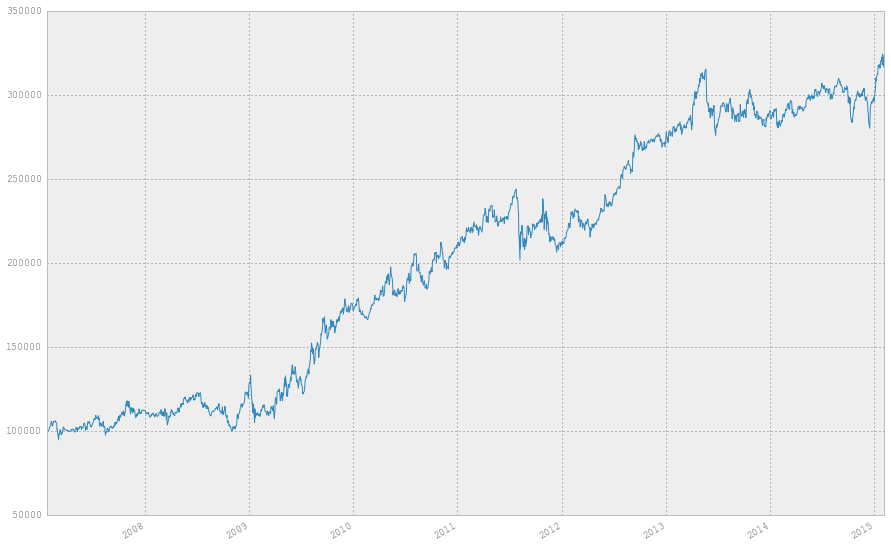

In [126]:
# to run specific backtest

p_name = 'test'
universe = universes[0]
lookback_days = 21
n_top = 2
func = TRMomentum

prices = dp_d.ix[:,:,"price"][universe]
df_scores = func(prices, lookback)


strategy_backtest (p_name, df_scores, prices, lookback_days=lookback_days, n_top=n_top, plot=True, print_out=True, save_metrics=False)

In [132]:
# average df_scores

df_scores = func(prices, lookback[0])
for window in lookback:
    df_scores = df_scores + func(prices, lookback[0])
    
df_scores = df_scores / len(lookback)

**** STATISTICS ****

('n_years        : ', 8.0383561643835613)
('cagr        : ', 15.424230612390044, '%')
('annual_factor    : ', 252)
('sharpe        : ', 0.82875311206689861)
('max_drawdown    : ', -21.150960772032011, '%')
('avg_drawdown    : ', -3.1882640156650961, '%')
('calmar        : ', -0.7292449160411455)
('R-squared    : ', 0.95946856995166696)
('DVR        : ', 0.79516256327782076)
('volatility    : ', 0.19676616716076162)
('VAR 5%       : ', -0.017180817815749459)
('CVAR 5%       : ', -0.029575806850748957)
**** STATISTICS ****

('n_years        : ', 7.8712328767123285)
('cagr        : ', 12.953576481955675, '%')
('annual_factor    : ', 252)
('sharpe        : ', 0.6756770187665555)
('max_drawdown    : ', -34.190947352245665, '%')
('avg_drawdown    : ', -1.0056160985954608, '%')
('calmar        : ', -0.37885982943098778)
('R-squared    : ', 0.94606126007648161)
('DVR        : ', 0.63923185177900799)
('volatility    : ', 0.21453812771438049)
('VAR 5%       : ', -0.01918207

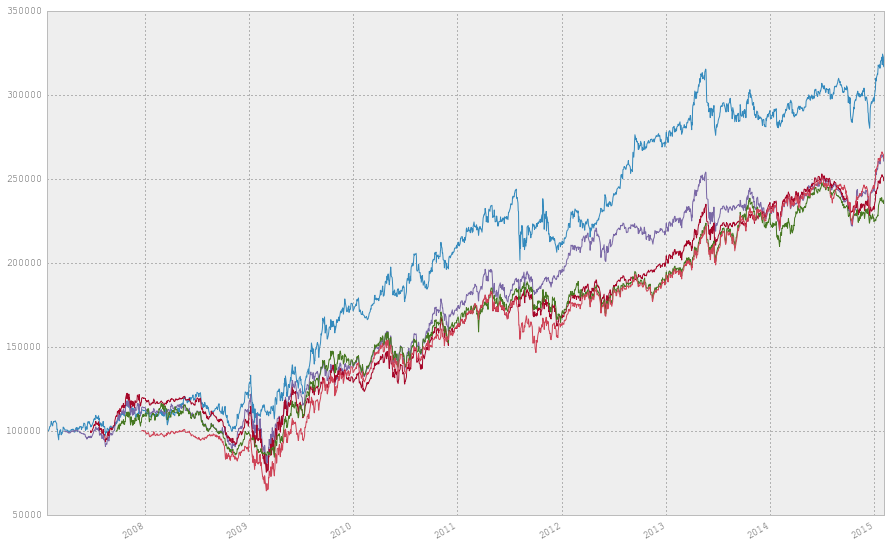

In [139]:
for lookback_days in lookback:
    strategy_backtest ('test', df_scores, prices, lookback_days=lookback_days, n_top=2, plot=True, print_out=True, save_metrics=False)